In [31]:
import pandas as pd
import numpy as np
import sys
import pickle
import glob
import os
import sqlite3
import peakutils
import matplotlib.pyplot as plt

In [32]:
FILE_IDX_FOR_ANALYSIS = 0

In [33]:
SEQUENCE_FILE_COUNTS_FILE_NAME = '/Users/darylwilding-mcbride/Downloads/sequence-charge-file-counts-df.pkl'

In [34]:
sequence_file_counts_df = pd.read_pickle(SEQUENCE_FILE_COUNTS_FILE_NAME)

In [35]:
sequence_file_counts_df.columns

Index(['sequence', 'charge', 'number_of_files', 'file_idxs'], dtype='object')

In [36]:
sequence_file_counts_df[sequence_file_counts_df.file_idxs.apply(lambda x: 0 not in x)].tail(20)

,sequence,charge,number_of_files,file_idxs
31283,n[42.0106]M[15.9949]APRPPTAAPQESVTFK,2,1,[5]
31284,n[42.0106]M[15.9949]AQTDKPTCIPPELPK,2,1,[19]
31285,n[42.0106]M[15.9949]ASGDFCSPGEGMEILQQVCSK,2,1,[16]
31287,n[42.0106]M[15.9949]DKVLDSALLSSANK,2,1,[5]
31288,n[42.0106]M[15.9949]DLLQFLAFLFVLLLSGM[15.9949]...,3,1,[16]
31290,n[42.0106]M[15.9949]EADASVDMFSK,2,1,[18]
31291,n[42.0106]M[15.9949]EDSMDMDMSPLRPQNYLFGCELK,3,7,"[1, 2, 11, 12, 14, 17, 18]"
31292,n[42.0106]M[15.9949]ESGLAGNGTGAGLVMKVK,2,1,[14]
31293,n[42.0106]M[15.9949]GNSDSQYTLQGSK,2,2,"[4, 19]"
31294,n[42.0106]M[15.9949]GPELGWGHPR,2,1,[2]


In [37]:
SEQUENCE_ROW_IDX_FOR_ANALYSIS = 31291

In [38]:
EXPERIMENT_SEQUENCE_ATTRIBS_FILE_NAME = '/Users/darylwilding-mcbride/Downloads/experiments/190719_Hela_Ecoli/training-sets/experiment-sequence-charge-attribs-df.pkl'

In [39]:
experiment_sequence_attribs_df = pd.read_pickle(EXPERIMENT_SEQUENCE_ATTRIBS_FILE_NAME)

In [40]:
experiment_sequence_attribs_df.head()

,sequence,charge,theoretical_mz,experiment_scan,experiment_scan_peak_width,experiment_rt,experiment_rt_peak_width,experiment_intensity
0,AAAAAAAAAPAAAATAPTTAATTAATAAQ,2,1184.1049,73.911301,57.626667,602.012681,18.706667,108754.444444
1,AAAAAAAAAPAAAATAPTTAATTAATAAQ,3,789.7394,335.868469,56.366667,609.864140,5.030000,29377.333333
2,AAAAAAAAVPSAGPAGPAPTSAAGR,2,1016.0286,160.291329,64.555556,489.973155,6.357111,58456.622222
3,AAAAALSQQQSLQER,2,785.9075,496.361511,45.912500,375.039574,6.140000,57092.250000
4,AAAAATVVPPMVGGPPFVGPVGFGPGDR,3,864.1171,707.537580,48.382593,1039.861047,16.666296,50988.518519


In [41]:
# use the run-0 model to find AAAAATVVPPMVGGPPFVGPVGFGPGDR, charge 3 in the raw data of the file idx
RUN_MZ_MODEL_FILE_NAME = '/Users/darylwilding-mcbride/Downloads/experiments/190719_Hela_Ecoli/trained-models/file-{}-mz-model.pkl'.format(FILE_IDX_FOR_ANALYSIS)
RUN_SCAN_MODEL_FILE_NAME = '/Users/darylwilding-mcbride/Downloads/experiments/190719_Hela_Ecoli/trained-models/file-{}-scan-model.pkl'.format(FILE_IDX_FOR_ANALYSIS)
RUN_RT_MODEL_FILE_NAME = '/Users/darylwilding-mcbride/Downloads/experiments/190719_Hela_Ecoli/trained-models/file-{}-rt-model.pkl'.format(FILE_IDX_FOR_ANALYSIS)

In [42]:
with open(RUN_MZ_MODEL_FILE_NAME, 'rb') as file:
    mz_estimator = pickle.load(file)
with open(RUN_SCAN_MODEL_FILE_NAME, 'rb') as file:
    scan_estimator = pickle.load(file)
with open(RUN_RT_MODEL_FILE_NAME, 'rb') as file:
    rt_estimator = pickle.load(file)

In [43]:
# gather the sequence attributes to plug into each model
sequence_df = pd.DataFrame(experiment_sequence_attribs_df.iloc[SEQUENCE_ROW_IDX_FOR_ANALYSIS]).transpose()

In [44]:
sequence_df

,sequence,charge,theoretical_mz,experiment_scan,experiment_scan_peak_width,experiment_rt,experiment_rt_peak_width,experiment_intensity
31291,n[42.0106]M[15.9949]EDSMDMDMSPLRPQNYLFGCELK,3,988.754,503.433,116.06,1004.41,19.4343,203452


In [45]:
sequence_estimation_attribs_df = sequence_df[['theoretical_mz','experiment_rt','experiment_scan','experiment_intensity']]
sequence_estimation_attribs = sequence_estimation_attribs_df.values

In [46]:
sequence_estimation_attribs

array([[988.7542, 1004.4117534472807, 503.43327254688006,
        203452.2857142857]], dtype=object)

In [47]:
# estimate the raw monoisotopic m/z
mz_delta_estimated = mz_estimator.predict(sequence_estimation_attribs)
estimated_monoisotopic_mz = sequence_estimation_attribs_df.iloc[0].theoretical_mz - mz_delta_estimated[0]
estimated_monoisotopic_mz

989.076912072016

In [48]:
# estimate the raw monoisotopic scan
scan_estimated = scan_estimator.predict(sequence_estimation_attribs)
estimated_scan_apex = scan_estimated[0]
estimated_scan_apex

501.1255049741394

In [49]:
# estimate the raw monoisotopic RT
rt_estimated = rt_estimator.predict(sequence_estimation_attribs)
estimated_rt_apex = rt_estimated[0]
estimated_rt_apex

1002.0583422827117

Look in the raw data for a feature at these coordinates

In [50]:
# the width to use for intensity descent, in m/z
MZ_TOLERANCE_PPM = 40  # +/- this amount
MZ_TOLERANCE_PERCENT = MZ_TOLERANCE_PPM * 10**-4
MS1_PEAK_DELTA = estimated_monoisotopic_mz * MZ_TOLERANCE_PERCENT / 100

In [51]:
MS1_PEAK_DELTA

0.03956307648288064

In [52]:
# Mass difference between Carbon-12 and Carbon-13 isotopes, in Da. For calculating the spacing between isotopic peaks.
CARBON_MASS_DIFFERENCE = 1.003355

# the collision energy to distinguish ms1 and ms2 frames
MS1_COLLISION_ENERGY = 10

In [53]:
# takes a numpy array of intensity, and another of mz
def mz_centroid(_int_f, _mz_f):
    return ((_int_f/_int_f.sum()) * _mz_f).sum()

In [54]:
# ms1_peaks_a is a numpy array of [mz,intensity]
# returns a numpy array of [mz_centroid,summed_intensity]
def ms1_intensity_descent(ms1_peaks_a):
    # intensity descent
    ms1_peaks_l = []
    while len(ms1_peaks_a) > 0:
        # find the most intense point
        max_intensity_index = np.argmax(ms1_peaks_a[:,1])
        peak_mz = ms1_peaks_a[max_intensity_index,0]
        peak_mz_lower = peak_mz - MS1_PEAK_DELTA
        peak_mz_upper = peak_mz + MS1_PEAK_DELTA

        # get all the raw points within this m/z region
        peak_indexes = np.where((ms1_peaks_a[:,0] >= peak_mz_lower) & (ms1_peaks_a[:,0] <= peak_mz_upper))[0]
        if len(peak_indexes) > 0:
            mz_cent = mz_centroid(ms1_peaks_a[peak_indexes,1], ms1_peaks_a[peak_indexes,0])
            summed_intensity = ms1_peaks_a[peak_indexes,1].sum()
            ms1_peaks_l.append((mz_cent, summed_intensity))
            # remove the raw points assigned to this peak
            ms1_peaks_a = np.delete(ms1_peaks_a, peak_indexes, axis=0)
    return np.array(ms1_peaks_l)


In [55]:
NUMBER_OF_ISOTOPES_RIGHT = 8     # the number of isotopes to look for in the m/z dimension
NUMBER_OF_ISOTOPES_LEFT = 0.5

expected_spacing_mz = CARBON_MASS_DIFFERENCE / sequence_df.iloc[0].charge

MZ_WIDTH_RIGHT_FROM_MONOISOTOPIC = NUMBER_OF_ISOTOPES_RIGHT * expected_spacing_mz
MZ_WIDTH_LEFT_FROM_MONOISOTOPIC = NUMBER_OF_ISOTOPES_LEFT * expected_spacing_mz

# distance for looking either side of the scan and RT apex
RT_WIDTH = sequence_df.iloc[0].experiment_rt_peak_width
SCAN_WIDTH = sequence_df.iloc[0].experiment_scan_peak_width

In [56]:
mz_lower = estimated_monoisotopic_mz - MZ_WIDTH_LEFT_FROM_MONOISOTOPIC
mz_upper = estimated_monoisotopic_mz + MZ_WIDTH_RIGHT_FROM_MONOISOTOPIC
scan_lower = estimated_scan_apex - SCAN_WIDTH
scan_upper = estimated_scan_apex + SCAN_WIDTH
rt_lower = estimated_rt_apex - RT_WIDTH
rt_upper = estimated_rt_apex + RT_WIDTH
print("mz: {}-{}, scan: {}-{}, rt: {}-{}".format(round(mz_lower,4), round(mz_upper,4), int(scan_lower), int(scan_upper), round(rt_lower,1), round(rt_upper,1)))

mz: 988.9097-991.7525, scan: 385-617, rt: 982.6-1021.5


In [57]:
# find the converted database file name for file idx 0
MAPPING_FILE_NAME = '/Users/darylwilding-mcbride/Downloads/percolator_mapping_df.pkl'
mapping_df = pd.read_pickle(MAPPING_FILE_NAME)

In [58]:
run_name = mapping_df[mapping_df.file_idx == FILE_IDX_FOR_ANALYSIS].iloc[0].run_name
run_name

'190719_Hela_Ecoli_1to3_06-recalibrated'

In [59]:
db_name = run_name.replace('-recalibrated', '-converted.sqlite')

In [60]:
CONVERTED_DATABASE_NAME = '/Users/darylwilding-mcbride/Downloads/experiments/190719_Hela_Ecoli/converted-databases/{}'.format(db_name)

In [61]:
CONVERTED_DATABASE_NAME

'/Users/darylwilding-mcbride/Downloads/experiments/190719_Hela_Ecoli/converted-databases/190719_Hela_Ecoli_1to3_06-converted.sqlite'

In [62]:
db_conn = sqlite3.connect(CONVERTED_DATABASE_NAME)
ms1_frame_properties_df = pd.read_sql_query("select frame_id,retention_time_secs from frame_properties where retention_time_secs >= {} and retention_time_secs <= {} and collision_energy == {} order by retention_time_secs".format(rt_lower, rt_upper, MS1_COLLISION_ENERGY), db_conn)
db_conn.close()
ms1_frame_ids = tuple(ms1_frame_properties_df.frame_id)

In [63]:
# extract the raw data within this area of interest
db_conn = sqlite3.connect(CONVERTED_DATABASE_NAME)
ms1_raw_points_df = pd.read_sql_query("select frame_id,mz,scan,intensity,retention_time_secs from frames where mz >= {} and mz <= {} and scan >= {} and scan <= {} and retention_time_secs >= {} and retention_time_secs <= {} and frame_id in {}".format(mz_lower, mz_upper, scan_lower, scan_upper, rt_lower, rt_upper, ms1_frame_ids), db_conn)
db_conn.close()

In [64]:
len(ms1_raw_points_df)

11421

In [65]:
ms1_raw_points_a = ms1_raw_points_df[['mz','intensity']].to_numpy()

In [66]:
# perform intensity descent to resolve peaks
peaks_a = ms1_intensity_descent(ms1_raw_points_a)

In [67]:
peaks_df = pd.DataFrame(peaks_a, columns=['mz_centroid','summed_intensity'])

In [68]:
peaks_df

,mz_centroid,summed_intensity
0,989.425291,193542.0
1,989.091105,124746.0
2,989.758883,181089.0
3,990.092465,132339.0
4,990.425949,80207.0
5,990.180819,43768.0
6,989.849861,39331.0
7,990.844903,15364.0
8,989.519787,40152.0
9,989.187456,39255.0


In [69]:
sequence_name = sequence_df.iloc[0].sequence
sequence_charge = sequence_df.iloc[0].charge

In [70]:
# a wider view for context
mz_lower_wide = mz_lower - 1
mz_upper_wide = mz_upper + 1
scan_lower_wide = scan_lower - 20
scan_upper_wide = scan_upper + 20
rt_lower_wide = rt_lower - 10
rt_upper_wide = rt_upper + 10

# extract the raw data within this area of interest
db_conn = sqlite3.connect(CONVERTED_DATABASE_NAME)
wide_ms1_raw_points_df = pd.read_sql_query("select frame_id,mz,scan,intensity,retention_time_secs from frames where mz >= {} and mz <= {} and scan >= {} and scan <= {} and retention_time_secs >= {} and retention_time_secs <= {} and frame_id in {}".format(mz_lower_wide, mz_upper_wide, scan_lower_wide, scan_upper_wide, rt_lower_wide, rt_upper_wide, ms1_frame_ids), db_conn)
db_conn.close()

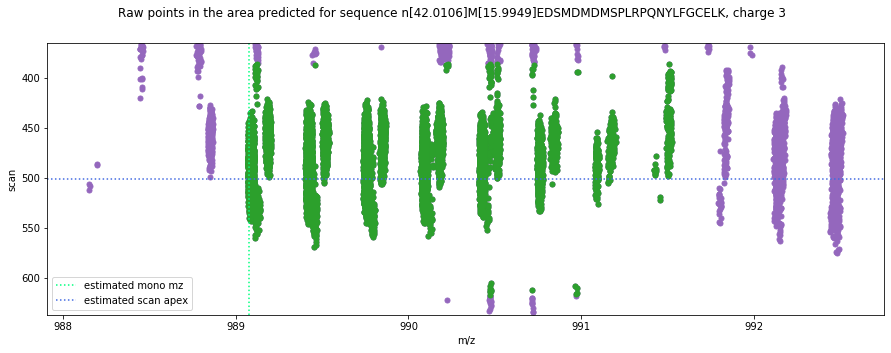

In [71]:
f, ax = plt.subplots()
ax.plot(wide_ms1_raw_points_df.mz, wide_ms1_raw_points_df.scan, marker='o', color='tab:purple', linestyle='', ms=5)
ax.plot(ms1_raw_points_df.mz, ms1_raw_points_df.scan, marker='o', color='tab:green', linestyle='', ms=5)
plt.axvline(x=estimated_monoisotopic_mz, linestyle=':', color='springgreen', label='estimated mono mz')
plt.axhline(y=estimated_scan_apex, linestyle=':', color='royalblue', label='estimated scan apex')
plt.xlabel('m/z')
plt.ylabel('scan')
plt.legend(loc='best')
plt.gca().invert_yaxis()
f.set_figheight(5)
f.set_figwidth(15)
plt.suptitle('Raw points in the area predicted for sequence {}, charge {}'.format(sequence_name, sequence_charge))
plt.xlim((mz_lower_wide,mz_upper_wide))
plt.ylim((scan_upper_wide,scan_lower_wide))
plt.margins(0.06)
plt.show()

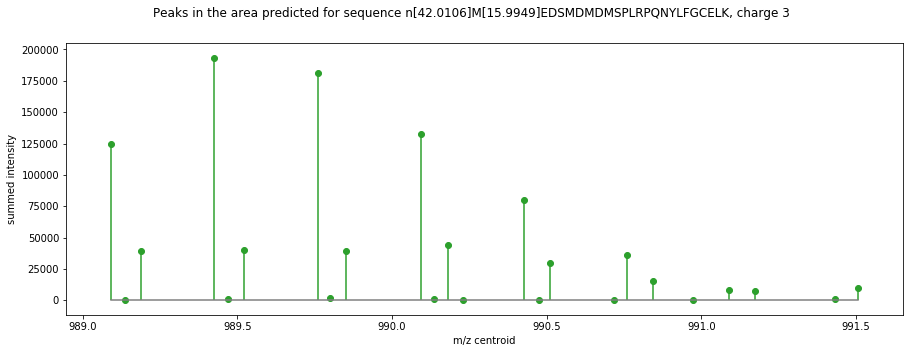

In [72]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
markerline, stemlines, baseline = ax.stem(peaks_df.mz_centroid, peaks_df.summed_intensity, 'g', use_line_collection=True)
plt.setp(markerline, 'color', colors[2])
plt.setp(stemlines, 'color', colors[2])
plt.setp(baseline, 'color', colors[7])
plt.xlabel('m/z centroid')
plt.ylabel('summed intensity')
f.set_figheight(5)
f.set_figwidth(15)
plt.margins(0.06)
plt.suptitle('Peaks in the area predicted for sequence {}, charge {}'.format(sequence_name, sequence_charge))
plt.show()

Gather the raw points belonging to the monoisotopic peak

In [73]:
mono_mz_lower = estimated_monoisotopic_mz - MS1_PEAK_DELTA
mono_mz_upper = estimated_monoisotopic_mz + MS1_PEAK_DELTA
mono_raw_points_df = ms1_raw_points_df[(ms1_raw_points_df.mz >= mono_mz_lower) & (ms1_raw_points_df.mz <= mono_mz_upper)].copy()

Collapse the points onto the mobility dimension

In [74]:
scan_df = mono_raw_points_df.groupby(['scan'], as_index=False).intensity.sum()

In [75]:
scan_df.sort_values(by=['scan'], ascending=True, inplace=True)

In [76]:
mobility_curve_fit = False
try:
    gaussian_params = peakutils.peak.gaussian_fit(scan_df.scan.values, scan_df.intensity.values, center_only=False)
    scan_apex_fitted = gaussian_params[1]
    scan_side_width = 2 * abs(gaussian_params[2])  # number of standard deviations either side of the apex
    scan_lower = scan_apex_fitted - scan_side_width
    scan_upper = scan_apex_fitted + scan_side_width
    g = peakutils.peak.gaussian(scan_df.scan, gaussian_params[0], gaussian_params[1], gaussian_params[2])
    mobility_curve_fit = True
    if (scan_apex_fitted >= wide_scan_lower) and (scan_apex_fitted <= wide_scan_upper):
        mobility_curve_fit = True
except:
    pass

# if we couldn't fit a curve to the mobility dimension, take the intensity-weighted centroid
if not mobility_curve_fit:
    print("could not fit a gaussian to the points - calculating the centroid")
    scan_apex_centroid = mz_centroid(scan_df.intensity.to_numpy(), scan_df.scan.to_numpy())
    scan_apex_max = scan_df.loc[scan_df.intensity.idxmax()].scan

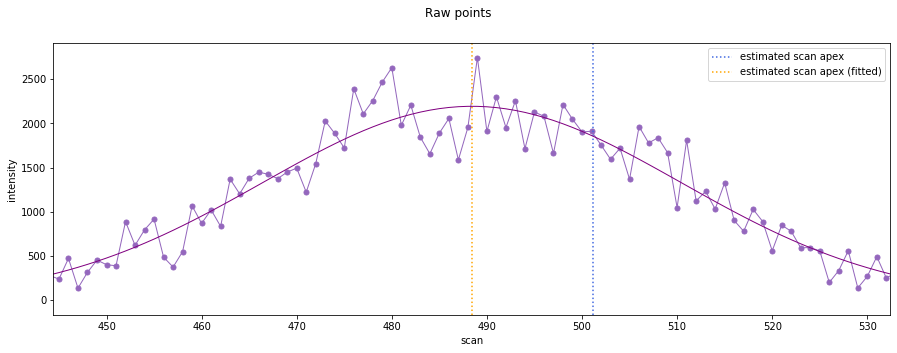

In [77]:
# visualise the monoisotopic peak in the scan dimension
f, ax = plt.subplots()
ax.plot(scan_df.scan.values, scan_df.intensity.values, marker='o', color='tab:purple', linestyle='-', linewidth=1, ms=5)
plt.axvline(x=estimated_scan_apex, linestyle=':', color='royalblue', label='estimated scan apex')
if mobility_curve_fit:
    plt.axvline(x=scan_apex_fitted, linestyle=':', color='orange', label='estimated scan apex (fitted)')
    ax.plot(scan_df.scan, g, marker='', color='purple', linestyle='-', linewidth=1, ms=5)
else:
    plt.axvline(x=scan_apex_centroid, linestyle=':', color='coral', label='calculated scan apex (centroid)')
    plt.axvline(x=scan_apex_max, linestyle=':', color='seagreen', label='calculated scan apex (max)')
plt.xlabel('scan')
plt.ylabel('intensity')
plt.legend(loc='best')
f.set_figheight(5)
f.set_figwidth(15)
plt.xlim((scan_lower,scan_upper))
plt.suptitle('Raw points')
plt.margins(0.06)
plt.show()

Collapse the points onto the RT dimension

In [78]:
rt_df = mono_raw_points_df.groupby(['frame_id','retention_time_secs'], as_index=False).intensity.sum()

In [79]:
rt_df.sort_values(by=['retention_time_secs'], ascending=True, inplace=True)

In [80]:
rt_curve_fit = False
try:
    gaussian_params = peakutils.peak.gaussian_fit(rt_df.retention_time_secs.values, rt_df.intensity.values, center_only=False)
    rt_apex_fitted = gaussian_params[1]
    rt_side_width = 3 * abs(gaussian_params[2])  # number of standard deviations either side of the apex
    rt_lower = rt_apex_fitted - rt_side_width
    rt_upper = rt_apex_fitted + rt_side_width
    g = peakutils.peak.gaussian(rt_df.retention_time_secs, gaussian_params[0], gaussian_params[1], gaussian_params[2])
    if (rt_apex_fitted >= rt_lower) and (rt_apex_fitted <= rt_upper):
        rt_curve_fit = True
except:
    pass

# if we couldn't fit a curve to the RT dimension, take the intensity-weighted centroid
if not rt_curve_fit:
    print("could not fit a gaussian to the points - calculating the centroid")
    rt_apex_centroid = mz_centroid(rt_df.intensity.to_numpy(), rt_df.retention_time_secs.to_numpy())
    rt_apex_max = rt_df.loc[rt_df.intensity.idxmax()].retention_time_secs

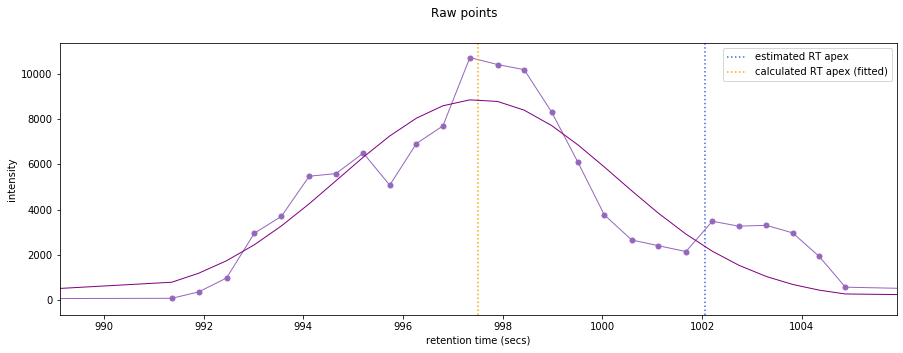

In [81]:
# visualise the monoisotopic peak in the RT dimension
f, ax = plt.subplots()
ax.plot(rt_df.retention_time_secs, rt_df.intensity, marker='o', color='tab:purple', linestyle='-', linewidth=1, ms=5)
plt.axvline(x=estimated_rt_apex, linestyle=':', color='royalblue', label='estimated RT apex')
if rt_curve_fit:
    plt.axvline(x=rt_apex_fitted, linestyle=':', color='orange', label='calculated RT apex (fitted)')
    ax.plot(rt_df.retention_time_secs, g, marker='', color='purple', linestyle='-', linewidth=1, ms=5)
else:
    plt.axvline(x=rt_apex_centroid, linestyle=':', color='coral', label='calculated RT apex (centroid)')
    plt.axvline(x=rt_apex_max, linestyle=':', color='seagreen', label='calculated RT apex (max)')
plt.xlabel('retention time (secs)')
plt.ylabel('intensity')
plt.legend(loc='best')
f.set_figheight(5)
f.set_figwidth(15)
plt.xlim((rt_lower,rt_upper))
plt.suptitle('Raw points')
plt.margins(0.06)
plt.show()